# This notebook classifies regulated flows from all realizations according to several metrics

NEEDS HISTORICAL REGULATED FLOWS

In [1]:
import os
import glob
import numpy as np
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import matplotlib
import matplotlib.colors as colors
import copy

In [2]:
# directory where the experiment data is stored
flow_data_dir = './xdd_parquet_flow'

Read **regulated** flows for all realizations

In [3]:
flow_only_path = os.path.join(flow_data_dir, f'S*_*.parquet')

# number of files in file query
n_files = len(glob.glob(flow_only_path))

# our target user
structure_id = '09163500'

sql = f"""
SELECT
    sample
    ,realization
    ,SUM(river_outflow) AS annual_river_outflow
    ,CASE month
            WHEN 'OCT' THEN year + 1
            WHEN 'NOV' THEN year + 1
            WHEN 'DEC' THEN year + 1
            WHEN 'JAN' THEN year
            WHEN 'FEB' THEN year
            WHEN 'MAR' THEN year
            WHEN 'APR' THEN year
            WHEN 'MAY' THEN year
            WHEN 'JUN' THEN year
            WHEN 'JUL' THEN year
            WHEN 'AUG' THEN year
            WHEN 'SEP' THEN year
            END AS water_year
FROM
    '{flow_only_path}'
GROUP BY
    structure_id
    ,water_year
    ,sample
    ,realization
HAVING
    structure_id = '{structure_id}'
ORDER BY
    sample
    ,realization
    ,water_year;
"""

# get query result as a data frame
df = duckdb.query(sql).df()

In [4]:
df[-12:]

,sample,realization,annual_river_outflow,water_year
102888,99,10,2741078.0,2002
102889,99,10,4322755.0,2003
102890,99,10,3352821.0,2004
102891,99,10,3450106.0,2005
102892,99,10,2952761.0,2006
102893,99,10,4616010.0,2007
102894,99,10,4226587.0,2008
102895,99,10,1580952.0,2009
102896,99,10,1287425.0,2010
102897,99,10,772983.0,2011


In [5]:
all_annual_experiment_flows = np.reshape(df['annual_river_outflow'].values, 
                                         (int(len(df)/n_files), n_files), order='F')
#convert to metric
all_annual_experiment_flows=all_annual_experiment_flows*1233.4818/1000000

Read in **naturalized** historic flows

In [39]:
historic_flows = np.load('historic_flows.npy')
annual_historic_flows = np.sum(historic_flows, axis=1)*1233.4818/1000000
reference_bad_flow = np.min(annual_historic_flows)
np.mean(annual_historic_flows)

6917.012489000795

In [44]:
np.mean(all_annual_experiment_flows, axis=0)

array([4160.31984974, 4116.6404031 , 4169.34177057, 4204.15581934,
       4141.83243627, 4176.31436125, 4254.43875191, 4182.85277808,
       4223.66725765, 4285.95149824, 3152.29211452, 3273.89212188,
       3382.13926585, 3155.99502688, 3334.28913531, 3219.05266055,
       3057.06767198, 3144.89241021, 3042.52212567, 3108.21965709,
       4665.37896982, 4532.48454525, 4580.90687037, 4483.20260078,
       4503.50757905, 4552.56828387, 4436.24560504, 4372.5076298 ,
       4180.63266356, 4460.37813608, 4426.55338671, 4169.76555968,
       4461.17610482, 4178.6941588 , 4452.39736786, 4460.90862723,
       3849.55028938, 4405.87432277, 4299.80884394, 4709.86788595,
       3664.8538113 , 3346.65869051, 3300.06547792, 3376.01508745,
       3445.10561012, 3645.12896888, 3402.95643275, 3322.3494309 ,
       3503.54253874, 3394.06810387, 4500.3075161 , 4480.63074424,
       4583.51297072, 4442.11891674, 4318.67944734, 4433.53580999,
       4311.32746116, 4475.08047555, 4313.09465291, 4372.81012

Function to count consecutive occurences

In [7]:
def count_max_flow_duration(sequence, flow):
    flow_occurence = [sequence[i]<=flow for i in range(len(sequence))] # Returns a list of True values where condition is met
    low_flows = sequence[flow_occurence]
    flow_duration = [ sum( 1 for _ in group ) for key, group in itertools.groupby( flow_occurence ) if key ] # Counts groups of True values
    return flow_duration, low_flows

In [8]:
flow_duration_list = []
low_flows_list = []
for j in range(len(all_annual_experiment_flows[0,:])):
    flow_duration, low_flows = count_max_flow_duration(all_annual_experiment_flows[:,j],
                                                       reference_bad_flow)
    flow_duration_list.append(flow_duration)
    low_flows_list.append(low_flows)
summary_occurences = [np.sum(flow_duration_list[j]) for j in range(len(all_annual_experiment_flows[0,:]))]
summary_occurences_order = np.argsort(summary_occurences)[::-1]
np.savetxt('realizations_order.txt', summary_occurences_order)

In [9]:
# Historic reference points
count_max_flow_duration(annual_historic_flows, reference_bad_flow)

([], array([], dtype=float64))

In [10]:
number_limit = n_files
x_values = list(np.arange(number_limit+1))
# Create dataframe of data to plot
max_flow = reference_bad_flow
min_flow = reference_bad_flow
max_duration = 1
min_duration = 1
flow_metrics = pd.DataFrame(columns = ['Low flow occurences X', 'Low flow occurences Y', 'Low flow colors',
                                       'Duration occurences X', 'Duration occurences Y', 'Duration colors', 
                                       'Flow mean', 'Flow variance'])
for j, k in zip(summary_occurences_order[:number_limit], x_values):
    all_occurences = len(low_flows_list[j])
    duration_occurences = len(flow_duration_list[j])
    flow_metrics = flow_metrics.append({'Low flow occurences X' : [x_values[k]] * all_occurences, 
                                        'Low flow occurences Y' : np.arange(all_occurences),
                                        'Low flow colors' : np.sort(low_flows_list[j]),
                                        'Duration occurences X' : [x_values[k]] * duration_occurences,
                                        'Duration occurences Y' : np.arange(duration_occurences),
                                        'Duration colors' : np.sort(flow_duration_list[j]),
                                        'Flow mean' : np.mean(all_annual_experiment_flows[:,j]),
                                        'Flow variance' : np.std(all_annual_experiment_flows[:,j])}, 
                                       ignore_index = True)
    if low_flows_list[j].any(): #only do this if array is not empty
        if min(low_flows_list[j]) < min_flow:
            min_flow=min(low_flows_list[j])
    if flow_duration_list[j]: #only do this if list is not empty
        if max(flow_duration_list[j]) > max_duration:
            max_duration=max(flow_duration_list[j])

In [30]:
# Identify historic reference points
historic_occurence = count_max_flow_duration(annual_historic_flows,reference_bad_flow)[0]
for j, k in zip(summary_occurences_order[:number_limit], x_values):
    if flow_duration_list[j] == historic_occurence:
        reference_index = k
        break

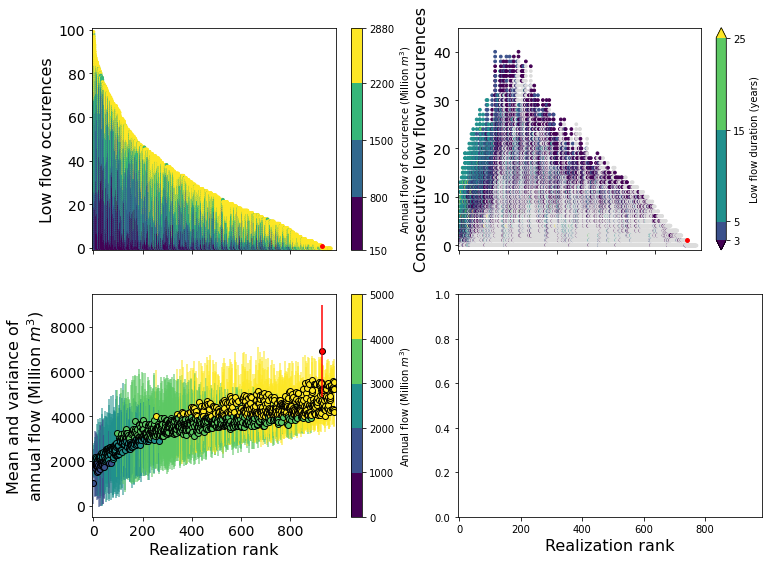

In [35]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(12,9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

flow_colormap = plt.cm.viridis 

duration_colormap = copy.copy(matplotlib.cm.get_cmap("viridis"))
duration_colormap.set_under('gainsboro', alpha=0.05)

flow_bounds = np.array([150, 800, 1500, 2200, max_flow])
normalize_flows = colors.BoundaryNorm(boundaries=flow_bounds, ncolors=256)

duration_bounds = np.array([2, 3, 5, 15, 25, max_duration])
normalize_durations = colors.BoundaryNorm(boundaries=duration_bounds, ncolors=256)

mean_flow_bounds = np.array([0, 1000, 2000, 3000, 4000, 5000])
normalize_mean_flows = colors.BoundaryNorm(boundaries=mean_flow_bounds, ncolors=256)

# Plot all realizations
for index, row in flow_metrics.iterrows():
    low_flow_points = ax1.scatter(row['Low flow occurences X'], row['Low flow occurences Y'], 
                            s=30, c=row['Low flow colors'], marker = '.', alpha=1,
                            cmap=flow_colormap, norm=normalize_flows, zorder=1)

    dur_points = ax2.scatter(row['Duration occurences X'], row['Duration occurences Y'], 
                           s=30, c=row['Duration colors'], marker = '.', alpha=1,
                           cmap=duration_colormap, norm=normalize_durations, zorder=1)
    
    flow_std = ax3.errorbar(index, row['Flow mean'], yerr=row['Flow variance'], 
                            ecolor=flow_colormap(normalize_mean_flows(row['Flow mean'])), 
                            alpha = 0.7, zorder=1)
    
    flow_points = ax3.scatter(index, row['Flow mean'], c=row['Flow mean'], marker = 'o',  
                              edgecolors = 'black', linewidth=1, alpha=1, cmap=flow_colormap, 
                              norm=normalize_mean_flows, zorder=2)

# Plot historic reference points
ax1.scatter(reference_index, 1, s=60, marker='.', c='red', zorder=2)
ax2.scatter(reference_index, 1, s=60, marker='.', c='red', zorder=2)
ax3.errorbar(reference_index, np.mean(annual_historic_flows), yerr=np.std(annual_historic_flows), 
             ecolor='red', zorder=3)
ax3.scatter(reference_index, np.mean(annual_historic_flows), marker = 'o',
            c='red', edgecolors = 'black', linewidth=1, alpha=1)

ax1.set_xlim([-5, number_limit+5])
ax2.set_xlim([-5, number_limit+5])
ax1.set_ylim([-1, 101]) 
ax2.set_ylim([-1, 45])

ax1.set_ylabel("Low flow occurences", fontsize=16)
ax2.set_ylabel("Consecutive low flow occurences", fontsize=16)
ax3.set_ylabel("Mean and variance of\nannual flow (Million $m^3$)", fontsize=16)

ax3.set_xlabel("Realization rank", fontsize=16)
ax4.set_xlabel("Realization rank", fontsize=16)

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)
ax3.tick_params(axis='both', labelsize=14)


fig.colorbar(low_flow_points, ax=ax1, boundaries = flow_bounds, 
             spacing='proportional', label = 'Annual flow of occurence (Million $m^3$)')
fig.colorbar(dur_points, ax=ax2, boundaries = duration_bounds, 
             spacing='proportional', label = 'Low flow duration (years)', extend='both')
fig.colorbar(flow_points, ax=ax3, label = 'Annual flow (Million $m^3$)')
plt.savefig('flows_metrics.png',dpi=120)
plt.show()